In [31]:
!pip list

Package                            Version
---------------------------------- -------------------
absl-py                            1.0.0
alabaster                          0.7.12
altair                             4.1.0
anaconda-client                    1.7.2
anaconda-navigator                 2.0.3
anaconda-project                   0.9.1
anyio                              2.2.0
appdirs                            1.4.4
argh                               0.26.2
argon2-cffi                        20.1.0
asn1crypto                         1.4.0
astor                              0.8.1
astroid                            2.5
astropy                            4.2.1
astunparse                         1.6.3
async-generator                    1.10
atomicwrites                       1.4.0
attrs                              20.3.0
autopep8                           1.5.6
Babel                              2.9.0
backcall                           0.2.0
backports.functools-lru-cache      1.6.4

In [30]:
# Importing the required packages for all your data framing needs.
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
from operator import attrgetter
import warnings
warnings.filterwarnings('ignore')

# Reading Data from Snowflake

In [3]:
# The Snowflake Connector library.
import snowflake.connector as snow
from snowflake.connector.pandas_tools import write_pandas

In [4]:
## Phase I: Truncate/Delete the current data in the table
# The connector...
conn = snow.connect(user="pranaliv95",
   password="Pranaliv@95",
   account="yv43311.us-east-2.aws",
   # (the prefix in your snowflake space... for example, 
   # company.snowflakecomputing.com would just be "company" as the ACCOUNT name)
   #warehouse="WAREHOUSE",
   database="BOOK_RECOMMENDATION",
   schema="PUBLIC")

In [5]:
# Create a cursor object.
cur = conn.cursor()

In [6]:
sql = "USE ROLE SYSADMIN"
cur.execute(sql)

In [7]:
# And then use it.
sql = "USE DATABASE BOOK_RECOMMENDATION"
cur.execute(sql)

In [8]:
# And then use it.
sql = "USE SCHEMA PUBLIC"
cur.execute(sql)

In [9]:
# sql = ("CREATE OR REPLACE TABLE COHORT_ANALYSIS"
#       "(BOOK_ID numeric, USER_ID numeric, DATE date, PRICE numeric, TRANSACTION_TYPE string)")

# cur.execute(sql)

In [10]:
# ## Phase II: Upload from the Exported Data File.
# # Let's import a new dataframe so that we can test this.
# original = r'C:\Users\nisar\Downloads\ADMProj\CohardAnalysisData.csv' # <- Replace with your path.
# delimiter = "," # Replace if you're using a different delimiter.

In [11]:
# # Get it as a pandas dataframe.
# total = pd.read_csv(original, sep = delimiter)

In [12]:
# # Actually write to the table in snowflake.
# write_pandas(conn, total, "COHORT_ANALYSIS")

In [13]:
cur = conn.cursor()
sql = "select * from COHORT_ANALYSIS"
cur.execute(sql)
 
df = cur.fetch_pandas_all()
 
df

,BOOK_ID,USER_ID,DATE,PRICE,TRANSACTION_TYPE
0,1,314,2018-05-18,191,ordered
1,1,439,2015-07-18,242,ordered
2,1,588,2016-10-30,282,ordered
3,1,1169,2015-08-28,378,sample
4,1,1185,2017-06-23,131,ordered
...,...,...,...,...,...
304435,10000,48386,2018-12-08,67,ordered
304436,10000,49007,2016-04-15,99,ordered
304437,10000,49383,2016-05-25,308,ordered
304438,10000,50124,2016-10-07,340,ordered


In [14]:
df['Order ID'] = np.random.randint(1000000,2000000,size=len(df))
df

,BOOK_ID,USER_ID,DATE,PRICE,TRANSACTION_TYPE,Order ID
0,1,314,2018-05-18,191,ordered,1723227
1,1,439,2015-07-18,242,ordered,1283698
2,1,588,2016-10-30,282,ordered,1338004
3,1,1169,2015-08-28,378,sample,1786947
4,1,1185,2017-06-23,131,ordered,1969100
...,...,...,...,...,...,...
304435,10000,48386,2018-12-08,67,ordered,1717025
304436,10000,49007,2016-04-15,99,ordered,1785499
304437,10000,49383,2016-05-25,308,ordered,1565734
304438,10000,50124,2016-10-07,340,ordered,1711928


In [15]:
indexNames = df[ (df['TRANSACTION_TYPE'] == 'sample')].index
df.drop(indexNames , inplace=True)
df

,BOOK_ID,USER_ID,DATE,PRICE,TRANSACTION_TYPE,Order ID
0,1,314,2018-05-18,191,ordered,1723227
4,1,1185,2017-06-23,131,ordered,1969100
15,1,9246,2016-11-04,245,ordered,1011829
18,1,10246,2015-04-29,128,ordered,1471471
19,1,10335,2016-06-23,292,ordered,1236431
...,...,...,...,...,...,...
304433,10000,48201,2018-11-05,247,ordered,1583918
304434,10000,48281,2018-01-18,405,ordered,1382410
304435,10000,48386,2018-12-08,67,ordered,1717025
304436,10000,49007,2016-04-15,99,ordered,1785499


In [16]:

#df['Date'] = pd.to_datetime(df['Date']).dt.date
df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')

In [17]:
n_orders = df.groupby(['USER_ID'])['Order ID'].nunique()
mult_orders_perc = np.sum(n_orders > 1) / df['USER_ID'].nunique()
print(f'{100 * mult_orders_perc:.2f}% of customers have order done transaction more than once.')

88.80% of customers have order done transaction more than once.


[Text(0.5, 1.0, 'Distribution of number of orders per customer'),
 Text(0.5, 0, '# of orders'),
 Text(0, 0.5, '# of customers')]

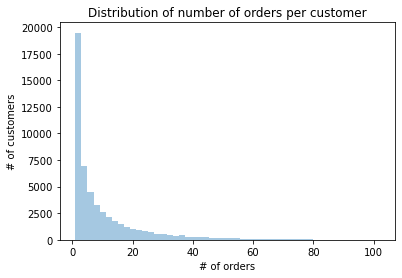

In [18]:
ax = sns.distplot(n_orders, kde=False, hist=True)
ax.set(title='Distribution of number of orders per customer',
       xlabel='# of orders', 
       ylabel='# of customers')

In [19]:
df1 = df[['USER_ID', 'Order ID', 'DATE']].drop_duplicates()
df1.head()

,USER_ID,Order ID,DATE
0,314,1723227,2018-05-18
4,1185,1969100,2017-06-23
15,9246,1011829,2016-11-04
18,10246,1471471,2015-04-29
19,10335,1236431,2016-06-23


In [25]:
df1['Transaction_Month'] = df1['DATE'].dt.to_period('M')
df1['Cohort'] = df1.groupby('USER_ID')['DATE'] \
                 .transform('min') \
                 .dt.to_period('M') 
df1.head()

,USER_ID,Order ID,DATE,Transaction_Month,Cohort
0,314,1723227,2018-05-18,2018-05,2015-01
4,1185,1969100,2017-06-23,2017-06,2015-02
15,9246,1011829,2016-11-04,2016-11,2015-01
18,10246,1471471,2015-04-29,2015-04,2015-01
19,10335,1236431,2016-06-23,2016-06,2015-02


In [26]:
df1_cohort = df1.groupby(['Cohort', 'Transaction_Month']) \
              .agg(n_customers=('USER_ID', 'nunique')) \
              .reset_index(drop=False)
df1_cohort['Period_Number'] = (df1_cohort.Transaction_Month - df1_cohort.Cohort).apply(attrgetter('n'))
df1_cohort.head()

,Cohort,Transaction_Month,n_customers,Period_Number
0,2015-01,2015-01,9188,0
1,2015-01,2015-02,2922,1
2,2015-01,2015-03,3141,2
3,2015-01,2015-04,3013,3
4,2015-01,2015-05,3048,4


In [27]:
cohort_pivot = df1_cohort.pivot_table(index = 'Cohort',
                                     columns = 'Period_Number',
                                     values = 'n_customers')
cohort_pivot

Period_Number,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
Cohort,,,,,,,,,,,,,,,,,,,,,
2015-01,9188.0,2922.0,3141.0,3013.0,3048.0,3054.0,3092.0,3142.0,3072.0,3044.0,...,2990.0,3174.0,2983.0,3073.0,3107.0,2998.0,3014.0,3019.0,3058.0,150.0
2015-02,5714.0,1503.0,1503.0,1564.0,1463.0,1578.0,1537.0,1499.0,1620.0,1561.0,...,1583.0,1556.0,1541.0,1561.0,1543.0,1553.0,1513.0,1588.0,69.0,NaN
2015-03,4648.0,1061.0,1039.0,1054.0,1008.0,1056.0,1007.0,981.0,1079.0,1070.0,...,1028.0,1100.0,1062.0,1006.0,1055.0,1064.0,1047.0,54.0,NaN,NaN
2015-04,3458.0,638.0,638.0,671.0,656.0,622.0,668.0,606.0,667.0,663.0,...,678.0,667.0,709.0,649.0,642.0,638.0,16.0,NaN,NaN,NaN
2015-05,2967.0,546.0,480.0,476.0,453.0,512.0,462.0,492.0,490.0,463.0,...,479.0,486.0,492.0,458.0,491.0,12.0,NaN,NaN,NaN,NaN
2015-06,2292.0,363.0,358.0,337.0,378.0,319.0,348.0,341.0,324.0,307.0,...,328.0,340.0,326.0,340.0,16.0,NaN,NaN,NaN,NaN,NaN
2015-07,2064.0,252.0,252.0,255.0,235.0,253.0,250.0,256.0,306.0,244.0,...,261.0,230.0,259.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
2015-08,1838.0,207.0,214.0,209.0,218.0,215.0,190.0,216.0,199.0,237.0,...,218.0,236.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09,1485.0,157.0,156.0,161.0,150.0,152.0,157.0,163.0,162.0,194.0,...,150.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
import joblib
filename = 'cohort.sav'
joblib.dump(cohort_pivot, filename)

['cohort.sav']

In [39]:
cohort_pivot = joblib.load(filename)
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
retention_matrix

Period_Number,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
Cohort,,,,,,,,,,,,,,,,,,,,,
2015-01,1.0,0.318024,0.341859,0.327928,0.331737,0.332390,0.336526,0.341968,0.334349,0.331302,...,0.325424,0.345451,0.324663,0.334458,0.338158,0.326295,0.328037,0.328581,0.332825,0.016326
2015-02,1.0,0.263038,0.263038,0.273714,0.256038,0.276164,0.268988,0.262338,0.283514,0.273189,...,0.277039,0.272314,0.269688,0.273189,0.270039,0.271789,0.264788,0.277914,0.012076,NaN
2015-03,1.0,0.228270,0.223537,0.226764,0.216867,0.227194,0.216652,0.211059,0.232143,0.230207,...,0.221170,0.236661,0.228485,0.216437,0.226979,0.228916,0.225258,0.011618,NaN,NaN
2015-04,1.0,0.184500,0.184500,0.194043,0.189705,0.179873,0.193175,0.175246,0.192886,0.191729,...,0.196067,0.192886,0.205032,0.187681,0.185656,0.184500,0.004627,NaN,NaN,NaN
2015-05,1.0,0.184024,0.161780,0.160431,0.152679,0.172565,0.155713,0.165824,0.165150,0.156050,...,0.161443,0.163802,0.165824,0.154365,0.165487,0.004044,NaN,NaN,NaN,NaN
2015-06,1.0,0.158377,0.156195,0.147033,0.164921,0.139180,0.151832,0.148778,0.141361,0.133944,...,0.143106,0.148342,0.142234,0.148342,0.006981,NaN,NaN,NaN,NaN,NaN
2015-07,1.0,0.122093,0.122093,0.123547,0.113857,0.122578,0.121124,0.124031,0.148256,0.118217,...,0.126453,0.111434,0.125484,0.003391,NaN,NaN,NaN,NaN,NaN,NaN
2015-08,1.0,0.112622,0.116431,0.113711,0.118607,0.116975,0.103373,0.117519,0.108270,0.128945,...,0.118607,0.128400,0.003264,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09,1.0,0.105724,0.105051,0.108418,0.101010,0.102357,0.105724,0.109764,0.109091,0.130640,...,0.101010,0.002694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
cohort_size_df

,cohort_size
Cohort,
2015-01,9188.0
2015-02,5714.0
2015-03,4648.0
2015-04,3458.0
2015-05,2967.0
2015-06,2292.0
2015-07,2064.0
2015-08,1838.0
2015-09,1485.0


         cohort_size
Cohort              
2015-01       9188.0
2015-02       5714.0
2015-03       4648.0
2015-04       3458.0
2015-05       2967.0
2015-06       2292.0
2015-07       2064.0
2015-08       1838.0
2015-09       1485.0
2015-10       1423.0
2015-11       1245.0
2015-12       1126.0
2016-01       1150.0
2016-02        868.0
2016-03        876.0
2016-04        860.0
2016-05        780.0
2016-06        721.0
2016-07        607.0
2016-08        602.0
2016-09        542.0
2016-10        535.0
2016-11        512.0
2016-12        484.0
2017-01        449.0
2017-02        363.0
2017-03        431.0
2017-04        397.0
2017-05        360.0
2017-06        349.0
2017-07        328.0
2017-08        312.0
2017-09        275.0
2017-10        257.0
2017-11        256.0
2017-12        236.0
2018-01        224.0
2018-02        207.0
2018-03        213.0
2018-04        217.0
2018-05        201.0
2018-06        163.0
2018-07        149.0
2018-08        156.0
2018-09        149.0
2018-10      

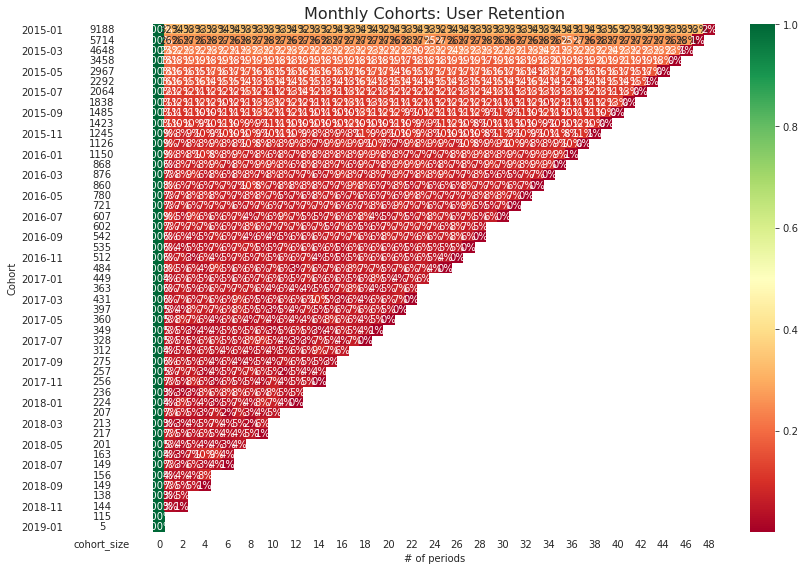

In [41]:
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    print(cohort_size_df)
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()